In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.tokenize import TreebankWordTokenizer

%matplotlib inline

# # pickle.dump(essays_lsa, open('../essays_lsa.pkl', 'wb'))
# essays_lsa = pickle.load(open('../essays_lsa.pkl', 'rb'))
# df_features = pickle.load(open('../df_features.pkl', 'rb'))

# X_train_lsa, X_test_lsa, y_train_lsa, y_test_lsa = train_test_split(essays_lsa,
#                                                                     df_features.student,
#                                                                     test_size=0.2,
#                                                                     stratify=df_features.student)

So here we are. Nothing from sklearn was able to make any kind of good predictions on the dataset, so now we are moving on to TensorFlow. We are going to build out a Recurrent Neural Network that takes in each sentence as a datapoint. Each sentence will be a sequence of words represented by an integer, and punctuation will be included in the representation.

In [2]:
df_features.head()

,subject,joined,student,tokens,lemmas
0,nursing,Total Word Count: This report has been prepare...,student,"(Total, Word, Count, :, This, report, has, bee...",total word count : this report have be prepare...
1,nursing,"Leadership has been described as ""a relational...",student,"(Leadership, has, been, described, as, "", a, r...","leadership have be describe as "" a relational ..."
2,nursing,Depression among pregnant adolescents as well ...,student,"(Depression, among, pregnant, adolescents, as,...",depression among pregnant adolescent as well a...
3,nursing,"Davidson, E., Daly, J., Brady, R. & Higgins, P...",student,"(Davidson, ,, E., ,, Daly, ,, J., ,, Brady, ,,...","davidson , e. , daly , j. , brady , r. & higgi..."
4,nursing,Idiopathic pulmonary fibrosis (IPF) is a devas...,student,"(Idiopathic, pulmonary, fibrosis, (, IPF, ), i...",idiopathic pulmonary fibrosis ( ipf ) be a dev...


In [2]:
rnn_df = pd.DataFrame(columns=['student', 'sentence', 'doc_no', 'sent_len'])
j = 0
max_length = 50
# for i, doc in enumerate(df_features.tokens):
#     for span in doc.sents:
#         if (len(span) <= max_length) and (len(span) >= 4):
#             rnn_df.loc[j, 'sentence'] = span
#             rnn_df.loc[j, 'student'] = df_features.loc[i, 'student']
#             rnn_df.loc[j, 'doc_no'] = i
#             rnn_df.loc[j, 'sent_len'] = len(span)
#             j += 1
rnn_df = pickle.load(open('../rnn_df.pkl', 'rb'))
rnn_df.head()

EOFError: Ran out of input

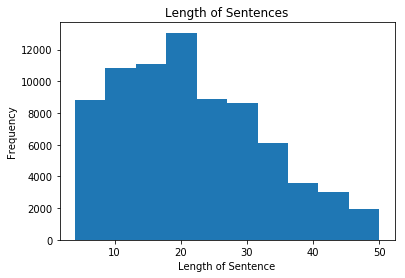

In [26]:
# For some reason plugging in the df was making the kernel hang. 
# Might have something to do with seaborn, Stack Overflow mentioned that
list_of_lengths = rnn_df.sent_len.tolist()
plt.hist(list_of_lengths)
plt.title('Length of Sentences')
plt.xlabel('Length of Sentence')
plt.ylabel('Frequency')
plt.show()

These are the lengths of the sequences we are going to feed into our RNN. We don't want them to be much longer than 50 because then we run into the vanishing gradient problem.

In [184]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=TreebankWordTokenizer().tokenize
                            ).fit(df_features.joined)
print(len(vectorizer.vocabulary_))

58493


In [2]:
# rnn_features = pd.DataFrame(columns=[])

# translate_dict = vectorizer.vocabulary_
# vocab_length = len(translate_dict)

# # Adding a few unicode strings to our dict
# translate_dict[u"\u2019s"] = vocab_length  + 1      # Curly single quote, 's
# translate_dict[u"\u00B0"] = vocab_length   + 2      # Degree, as in celsius
# translate_dict[u"n\u2019t"] = vocab_length + 3      # n't
# translate_dict[u"\u0022"] = vocab_length   + 4      # double straight quote "



for i, span in enumerate(rnn_df.sentence):
    span_length = len(span)
    for j in range(max_length+1):
        if j < span_length:
            try:
                rnn_features.loc[i, j] = translate_dict[span[j].lower_]
            except:
                if len(span[j]) > 10:
                    rnn_features.loc[i, j] = None
                else:
                    rnn_features.loc[i, j] = vocab_length + 5
        elif j <= 49:
            rnn_features.loc[i, j] = vocab_length + 6
        else:
            rnn_features.loc[i, j] = rnn_df.doc_no[i]
            rnn_features.loc[i, j+1] = rnn_df.student[i]
            rnn_features.loc[i, j+2] = rnn_df.sent_len[i]
    if i % 5000 == 0:
        print('Working on row: {}'.format(i))

max_length = 50
rnn_features = pickle.load(open('../rnn_features.pkl', 'rb'))

rnn_features.rename({max_length:'doc_no', max_length+1:'target', max_length+2:'sent_len'}, axis=1, inplace=True)
print('Total sentences:', len(rnn_features))
rnn_features.dropna(inplace=True)
rnn_features.reset_index(inplace=True, drop=True)
print('Usable sentences:', len(rnn_features))
rnn_features.head()

Total sentences: 74666
Usable sentences: 74666


,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,doc_no,target,sent_len
0,53832.0,57582.0,16771.0,6446.0,53276.0,45952.0,26995.0,10833.0,42962.0,24320.0,...,58503.0,58503.0,58503.0,58503.0,58503.0,58503.0,58503.0,0.0,student,32.0
1,36738.0,54382.0,56784.0,6541.0,5555.0,57942.0,38945.0,32412.0,57221.0,26587.0,...,58503.0,58503.0,58503.0,58503.0,58503.0,58503.0,58503.0,0.0,student,23.0
2,53022.0,18939.0,56784.0,32581.0,45348.0,53624.0,43574.0,33051.0,763.0,6541.0,...,58503.0,58503.0,58503.0,58503.0,58503.0,58503.0,58503.0,0.0,student,31.0
3,19444.0,53669.0,57461.0,14058.0,15564.0,27418.0,11586.0,43415.0,13096.0,879.0,...,58503.0,58503.0,58503.0,58503.0,58503.0,58503.0,58503.0,0.0,student,10.0
4,48937.0,26587.0,33855.0,57198.0,11586.0,16771.0,763.0,33855.0,41882.0,16771.0,...,58503.0,58503.0,58503.0,58503.0,58503.0,58503.0,58503.0,0.0,student,22.0


In [3]:
# import winsound
# frequency = np.random.randint(2000, 4000, 50)  # Set Frequency 
# duration = 25  # Set Duration To 1000 ms == 1 second
# for each in frequency:
#     winsound.Beep(each, duration)

In [4]:
# pickle.dump(rnn_features, open('../rnn_features.pkl', 'wb'))

In [5]:
from __future__ import print_function

import tensorflow as tf
import random

C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
# ====================
#  TOY DATA GENERATOR
# ====================

class SequenceData(object):
    """ Generate sequence of data with dynamic length.
    This class generate samples for training:
    - Class 0: linear sequences (i.e. [0, 1, 2, 3,...])
    - Class 1: random sequences (i.e. [1, 3, 10, 7,...])

    NOTICE:
    We have to pad each sequence to reach 'max_seq_len' for TensorFlow
    consistency (we cannot feed a numpy array with inconsistent
    dimensions). The dynamic calculation will then be perform thanks to
    'seqlen' attribute that records every actual sequence length.
    """
    def __init__(self, df_features):
        self.data = []
        self.labels = []
        self.seqlen = []
        n_samples = len(df_features)
        
        for i, row in enumerate(df_features.iloc[:, 0:50].values):
            row_list = []
            for component in row:
                row_list.append([int(component)])
            self.data.append(row_list)
            
            if df_features.iloc[i, 51] == 'student':
                self.labels.append([1., 0.])
            else:
                self.labels.append([0., 1.])
                
            # Monitor sequence length for TensorFlow dynamic calculation
            self.seqlen.append(df_features.iloc[i, 52])
        self.batch_id = 0

    def next(self, batch_size):
        """ Return a batch of data. When dataset end is reached, start over.
        """
        if self.batch_id == len(self.data):
            self.batch_id = 0
        batch_data = (self.data[self.batch_id:min(self.batch_id +
                                                  batch_size, len(self.data))])
        batch_labels = (self.labels[self.batch_id:min(self.batch_id +
                                                  batch_size, len(self.data))])
        batch_seqlen = (self.seqlen[self.batch_id:min(self.batch_id +
                                                  batch_size, len(self.data))])
        self.batch_id = min(self.batch_id + batch_size, len(self.data))
        return batch_data, batch_labels, batch_seqlen

# Test it out
# this = SequenceData(rnn_features)

In [7]:
X_train, X_test = train_test_split(rnn_features, test_size = 0.2, stratify=rnn_features.target)

In [8]:
# ==========
#   MODEL
# ==========

# Parameters
learning_rate = 0.01
training_steps = 1000
batch_size = 128
display_step = 200

# Network Parameters
seq_max_len = 50 # Sequence max length
n_hidden = 64 # hidden layer num of features
n_classes = 2 # linear sequence or not

new_data = True
if new_data:
    trainset = SequenceData(X_train)
    testset = SequenceData(X_test)
else:
    trainset = pickle.load(open('../trainset_tf.pkl', 'rb'))
    testset = pickle.load(open('../testset_tf.pkl', 'rb'))
    
# tf Graph input
x = tf.placeholder("float", [None, seq_max_len, 1])
y = tf.placeholder("float", [None, n_classes])
# A placeholder for indicating each sequence length
seqlen = tf.placeholder(tf.int32, [None])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [9]:
# pickle.dump(trainset, open('../trainset_tf.pkl', 'wb'))
# pickle.dump(testset, open('../testset_tf.pkl', 'wb'))

In [10]:
def dynamicRNN(x, seqlen, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)
    
    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, seq_max_len, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden)

    # Get lstm cell output, providing 'sequence_length' will perform dynamic
    # calculation.
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x, dtype=tf.float32,
                                sequence_length=seqlen)

    # When performing dynamic calculation, we must retrieve the last
    # dynamically computed output, i.e., if a sequence length is 10, we need
    # to retrieve the 10th output.
    # However TensorFlow doesn't support advanced indexing yet, so we build
    # a custom op that for each sample in batch size, get its length and
    # get the corresponding relevant output.

    # 'outputs' is a list of output at every timestep, we pack them in a Tensor
    # and change back dimension to [batch_size, n_step, n_input]
    outputs = tf.stack(outputs)
    outputs = tf.transpose(outputs, [1, 0, 2])

    # Hack to build the indexing and retrieve the right output.
    batch_size = tf.shape(outputs)[0]
    # Start indices for each sample
    index = tf.range(0, batch_size) * seq_max_len + (seqlen - 1)
    # Indexing
    outputs = tf.gather(tf.reshape(outputs, [-1, n_hidden]), index)

    # Linear activation, using outputs computed above
    return tf.matmul(outputs, weights['out']) + biases['out']

In [11]:
pred = dynamicRNN(x, seqlen, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(targets=y, logits=pred, pos_weight=2))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [12]:
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        batch_x, batch_y, batch_seqlen = trainset.next(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,
                                       seqlen: batch_seqlen})
        if step % display_step == 0 or step == 1:
            # Calculate batch accuracy & loss
            acc, loss = sess.run([accuracy, cost], feed_dict={x: batch_x, y: batch_y,
                                                seqlen: batch_seqlen})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy
    test_data = testset.data
    test_label = testset.labels
    test_seqlen = testset.seqlen
    y_final_pred = sess.run(pred, feed_dict={x: test_data, y: test_label,
                                             seqlen: test_seqlen})


Step 1, Minibatch Loss= 0.746188, Training Accuracy= 0.92188
Step 200, Minibatch Loss= 0.298234, Training Accuracy= 0.95312
Step 400, Minibatch Loss= 0.510836, Training Accuracy= 0.88281
Step 600, Minibatch Loss= 0.384593, Training Accuracy= 0.92188
Step 800, Minibatch Loss= 0.597474, Training Accuracy= 0.85156
Step 1000, Minibatch Loss= 0.393634, Training Accuracy= 0.91406
Optimization Finished!


In [13]:
y_final_pred

array([[ 3.126489 , -1.7164415],
       [ 3.1264887, -1.716441 ],
       [ 3.126489 , -1.7164415],
       ...,
       [ 3.126489 , -1.7164415],
       [ 3.1303556, -1.4746436],
       [ 3.1264842, -1.7164391]], dtype=float32)

In [27]:
y_pred_ = np.argmax(y_final_pred, axis=1)
y_pred_.mean()

0.0

In [26]:
sum(testset.labels[:][0])

1.0